In [67]:
# Libraries

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
import math
import warnings
warnings.filterwarnings('ignore')

In [40]:
# Load data

data = pd.read_csv('KES Vs. USDD.csv')
data.head()

,Date,Currency,Mean,Buy,Sell
0,04/10/2023,US DOLLAR,148.4500,148.3500,148.5500
1,03/10/2023,US DOLLAR,148.3176,148.2176,148.4176
2,02/10/2023,US DOLLAR,148.2015,148.1029,148.3000
3,29/09/2023,US DOLLAR,148.1000,148.0000,148.2000
4,28/09/2023,US DOLLAR,147.9412,147.8412,148.0412


In [41]:
# Data info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4752 entries, 0 to 4751
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      4752 non-null   object 
 1   Currency  4752 non-null   object 
 2   Mean      4752 non-null   float64
 3   Buy       4752 non-null   float64
 4   Sell      4752 non-null   float64
dtypes: float64(3), object(2)
memory usage: 185.8+ KB


In [42]:
# Missing values

data.isnull().sum()

Date        0
Currency    0
Mean        0
Buy         0
Sell        0
dtype: int64

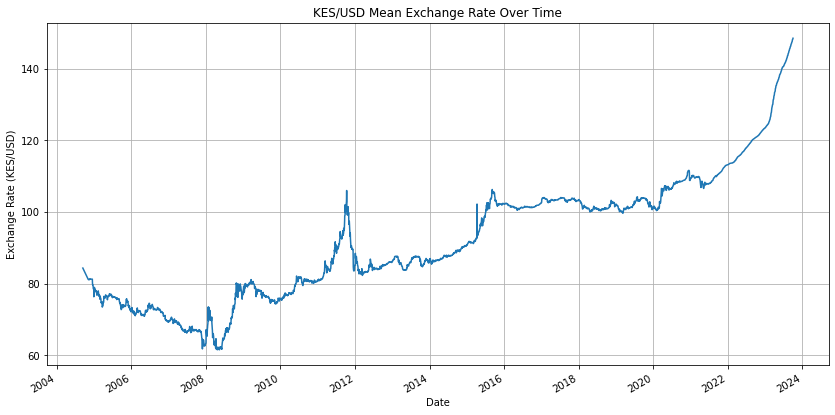

In [43]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Set the Date as index
data.set_index('Date', inplace=True)

# Plot the 'Mean' exchange rate over time
plt.figure(figsize=(14, 7))
data['Mean'].plot(title='KES/USD Mean Exchange Rate Over Time')
plt.ylabel('Exchange Rate (KES/USD)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

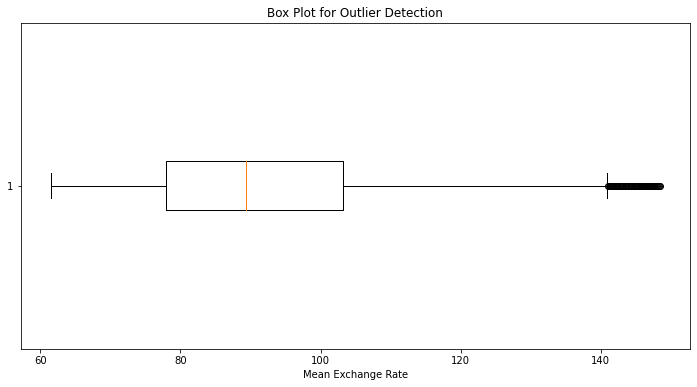

(None,
 count    4752.000000
 mean       92.313399
 std        17.159190
 min        61.510600
 25%        77.957625
 50%        89.365950
 75%       103.195375
 max       148.450000
 Name: Mean, dtype: float64)

In [44]:
# Descriptive statistics
descriptive_stats = data['Mean'].describe()

# Box plot for outlier detection
plt.figure(figsize=(12, 6))
plt.boxplot(data['Mean'], vert=False)
plt.title('Box Plot for Outlier Detection')
plt.xlabel('Mean Exchange Rate')

# Show the plot and the descriptive statistics
plt.show(), descriptive_stats

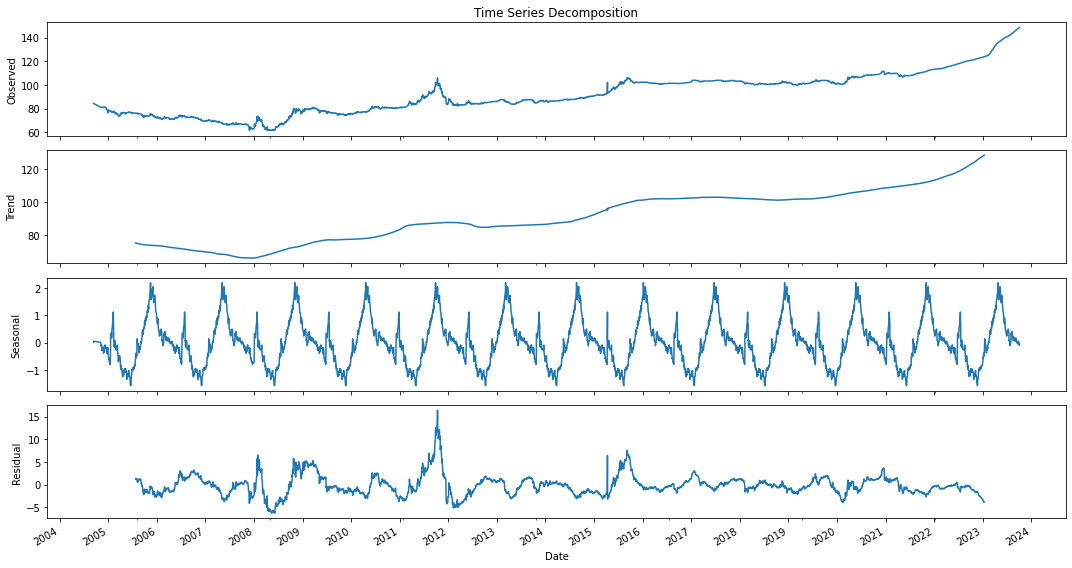

(-3.5603068053857845, 0.006566824515957058)

In [45]:
# Decompose the time series to observe trends and seasonality
decomposition = seasonal_decompose(data['Mean'], model='additive', period=365)

# Plot the decomposed time series
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8), sharex=True)

# Using a yearly locator for clearer representation on the x-axis
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)

# Plot each component
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Time Series Decomposition')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test to check stationarity
result = adfuller(data['Mean'])
adf_statistic, p_value = result[0], result[1]

adf_statistic, p_value

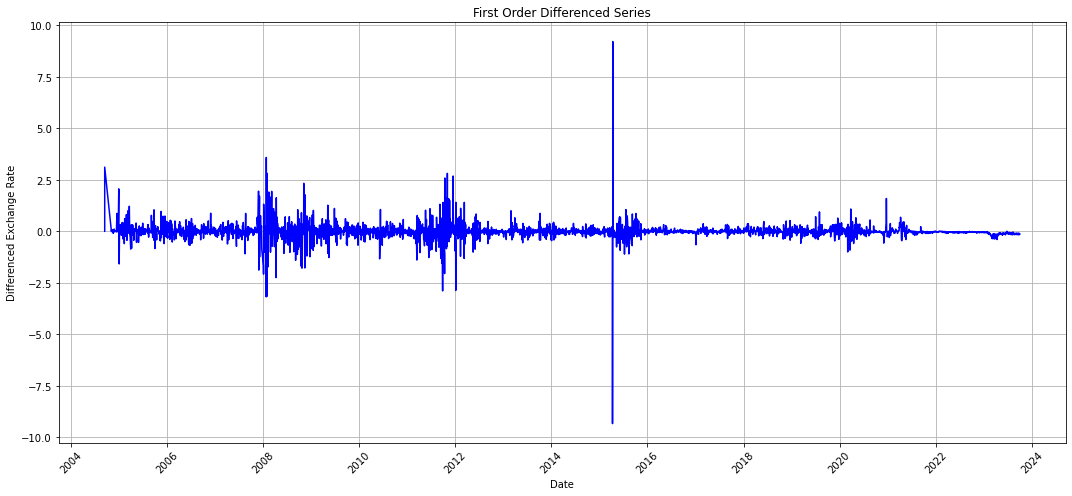

(None, (-12.186170118391148, 1.3172188538894572e-22))

In [48]:
# Apply first-order differencing
data['First_Difference'] = data['Mean'] - data['Mean'].shift(1)

# Drop the NaN value generated by differencing
data_diff = data.dropna(subset=['First_Difference'])

# Perform Augmented Dickey-Fuller test again to check stationarity
result_diff = adfuller(data_diff['First_Difference'])
adf_statistic_diff, p_value_diff = result_diff[0], result_diff[1]

# Plot the differenced data
plt.figure(figsize=(15, 7))
plt.plot(data_diff.index, data_diff['First_Difference'], color='blue')  # changed 'Date' to data_diff.index
plt.title('First Order Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Exchange Rate')
plt.grid(visible=True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot and the new ADF test results
plt.show(), (adf_statistic_diff, p_value_diff)

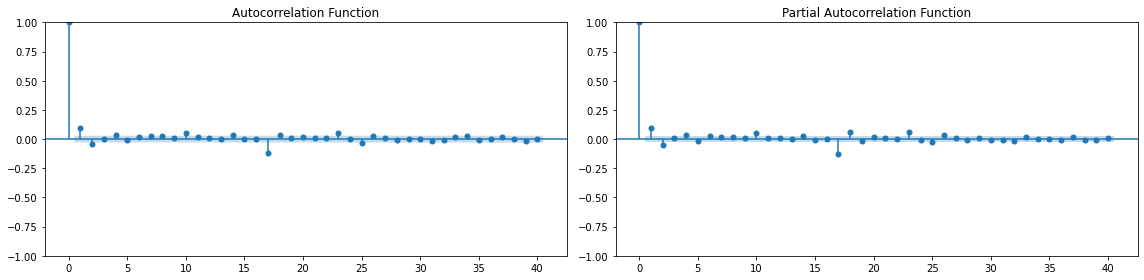

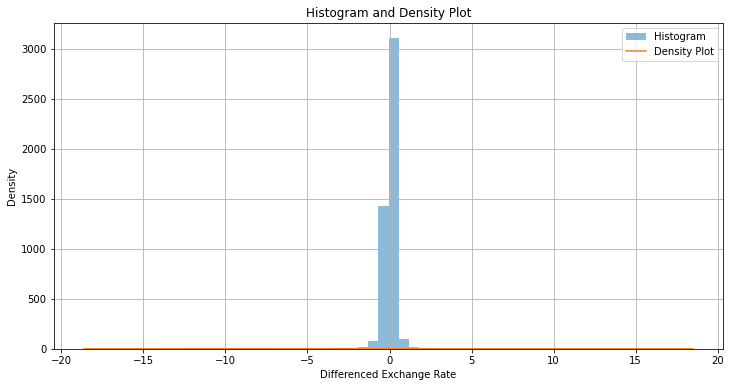

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(data_diff['First_Difference'], ax=ax1, lags=40, title='Autocorrelation Function')

# Plot PACF
plot_pacf(data_diff['First_Difference'], ax=ax2, lags=40, title='Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# Now we create histogram and density plots
plt.figure(figsize=(12, 6))

# Histogram
data_diff['First_Difference'].hist(bins=30, alpha=0.5, label='Histogram')

# Density plot
data_diff['First_Difference'].plot(kind='kde', label='Density Plot')

plt.title('Histogram and Density Plot')
plt.xlabel('Differenced Exchange Rate')
plt.legend()
plt.grid(visible=True)
plt.show()


In [60]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to train ARIMA model and compute the AIC
def train_arima(data, order):
    # Fit the ARIMA model
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    
    # Return the AIC and the model
    return model_fit.aic, model_fit

# Splitting the data into train and test sets (keeping the last 7 points for testing)
train_data = data_diff['First_Difference'][:-7]
test_data = data_diff['First_Difference'][-7:]

# Parameters for ARIMA based on our analysis
p_values = [1, 2]
d_values = [1]  # since we've already differenced once
q_values = [1, 2]

# Grid search for parameters
best_score, best_order, best_model = float("inf"), None, None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, model = train_arima(train_data, order)
                
                # Check if this is the best model based on AIC
                if aic < best_score:
                    best_score, best_order, best_model = aic, order, model
            except:
                continue  # move to next parameters if the current one fails

# Summary of the best model
best_order, best_model.summary()

((2, 1, 1),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:       First_Difference   No. Observations:                 4744
 Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1867.172
 Date:                Sun, 29 Oct 2023   AIC                           3742.344
 Time:                        14:07:16   BIC                           3768.202
 Sample:                             0   HQIC                          3751.431
                                - 4744                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          0.0964      0.006     16.662      0.000       0.085       0.108
 ar.L2         -0.0551      0.006     -8.994      0.000   

The best model based on the AIC is an ARIMA(2, 1, 1), indicating:
- 2 autoregressive terms (as suggested by the PACF plot where we saw a sharp drop after lag 2),
- 1 differencing (which we already applied to make the series stationary), and
- 1 moving average term (as suggested by the ACF plot with a sharp drop after lag 1).

c:\Users\Pius\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


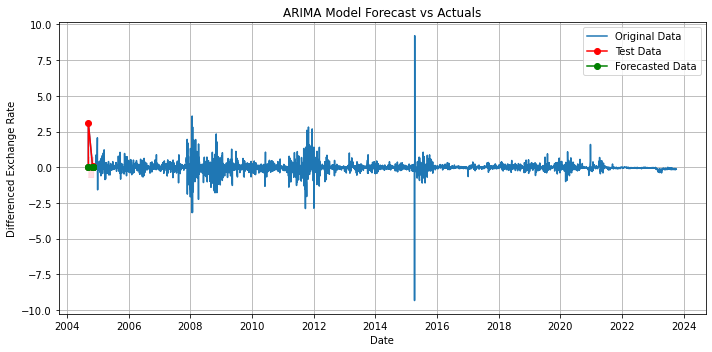

1.1686453804304036

In [52]:
# Forecasting with the best model
forecast = best_model.get_forecast(steps=7)  # we have 7 data points in the test set
mean_forecast = forecast.predicted_mean

# We should also get a measure of the accuracy of the forecast
conf_int = forecast.conf_int()

# Performance check with mean squared error
mse = mean_squared_error(test_data, mean_forecast)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Plotting the forecast along with confidence interval
plt.figure(figsize=(10, 5))

# Original data and test data
plt.plot(data_diff.index, data_diff['First_Difference'], label='Original Data')
plt.plot(data_diff.index[-7:], test_data, marker='o', color='red', label='Test Data')

# Forecasted data
plt.plot(data_diff.index[-7:], mean_forecast, marker='o', color='green', label='Forecasted Data')

# Confidence intervals
plt.fill_between(data_diff.index[-7:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5)

plt.title('ARIMA Model Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Differenced Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Return the RMSE
rmse

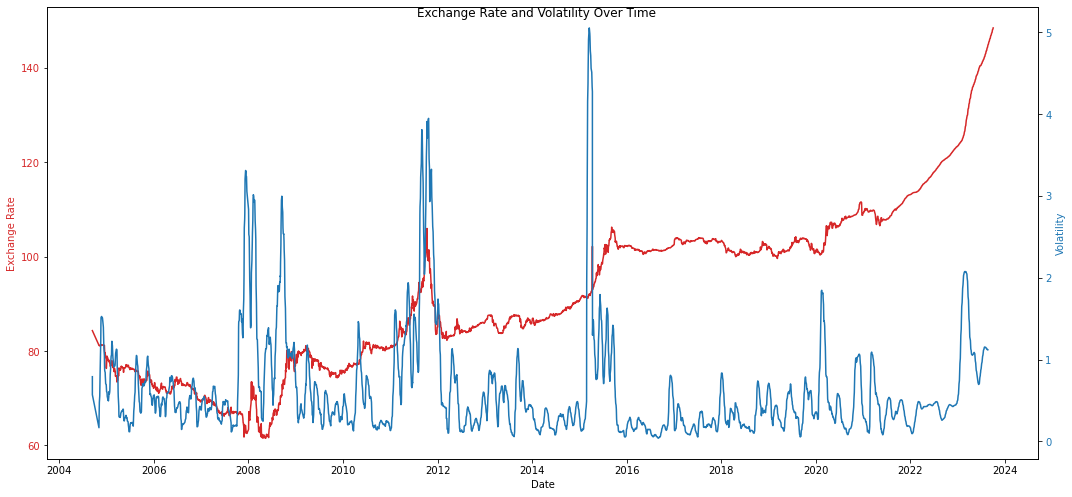

In [54]:
# Calculate the rolling standard deviation (rolling window of 30 days) as a measure of volatility
window = 30  # typical month duration
data['Volatility'] = data['Mean'].rolling(window=window).std()

# Create a plot for the exchange rate and another for its volatility
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Exchange Rate', color=color)
ax1.plot(data.index, data['Mean'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Volatility', color=color)
ax2.plot(data.index, data['Volatility'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to make sure the right y-label is not slightly clipped
fig.suptitle('Exchange Rate and Volatility Over Time')
plt.show()

In [56]:
# Identifying the periods of highest volatility
# We will look for points where the volatility exceeds a certain threshold that is significantly higher than the average volatility

# Threshold set to mean + 1.5 standard deviations, a common criterion for identifying outliers
threshold = data['Volatility'].mean() + 1.5 * data['Volatility'].std()

# Filter the data to find where volatility is significantly high
high_volatility_periods = data[data['Volatility'] > threshold]

# Extract the dates of these periods
high_volatility_dates = high_volatility_periods.index

high_volatility_dates

DatetimeIndex(['2023-03-28', '2023-03-27', '2023-03-24', '2023-03-23',
               '2023-03-22', '2023-03-21', '2023-03-20', '2023-03-17',
               '2023-03-16', '2023-03-15',
               ...
               '2007-12-07', '2007-12-06', '2007-12-05', '2007-12-04',
               '2007-12-03', '2007-11-30', '2007-11-29', '2007-11-28',
               '2007-11-27', '2007-11-26'],
              dtype='datetime64[ns]', name='Date', length=300, freq=None)

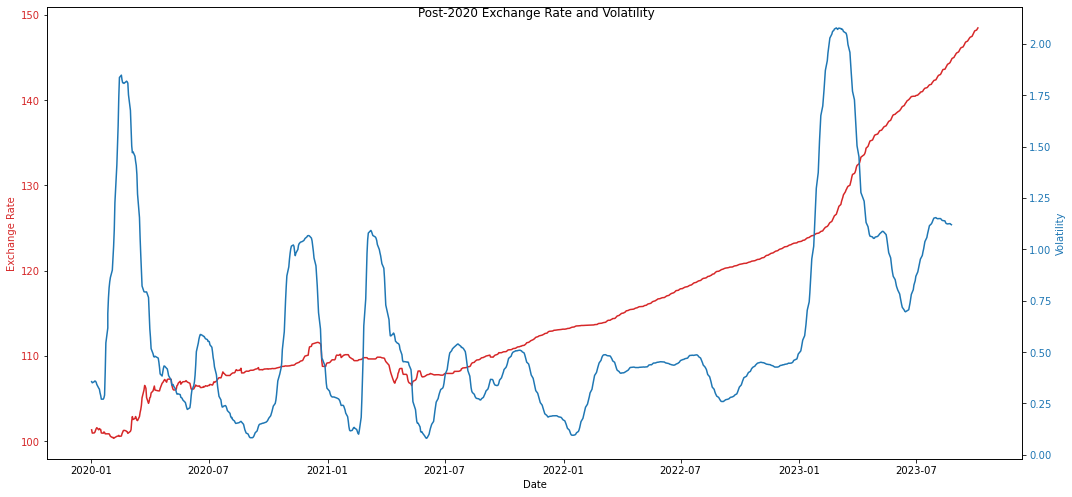

In [63]:
# Filter data for the post-2020 period
data_post_2020 = data[data.index >= '2020-01-01']

# Create a plot for the exchange rate and its volatility during the post-2020 period
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Exchange Rate', color=color)
ax1.plot(data_post_2020.index, data_post_2020['Mean'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Volatility', color=color)
ax2.plot(data_post_2020.index, data_post_2020['Volatility'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to make sure the right y-label is not slightly clipped
fig.suptitle('Post-2020 Exchange Rate and Volatility')
plt.show()

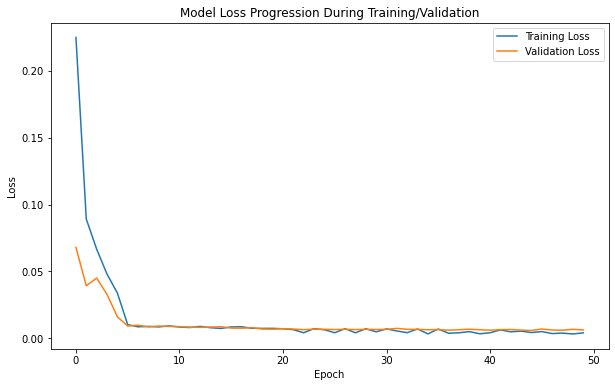

In [65]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Data Preparation
# We will work with the 'Mean' exchange rate
values = data['Mean'].values.reshape(-1, 1)

# Normalize features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Splitting the data into train and test sets
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1, timesteps = 3
look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM Network building
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=Adam(learning_rate=0.001))

# Fitting the model with the data
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_test, Y_test), verbose=0, shuffle=False)

# Plotting the training progression
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [68]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_inverse = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inverse = scaler.inverse_transform([Y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train_inverse[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test_inverse[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

  1/119 [..............................] - ETA: 5s

30/30 [==============================] - 0s 3ms/step
Train Score: 0.93 RMSE
Test Score: 0.74 RMSE


In [80]:
# Sort the DataFrame by date if it's not already sorted
data = data.sort_index()

# Confirm the last date in the DataFrame
print("Last date available in data:", data.index[-1])  # This should print the most recent date


Last date available in data: 2023-10-04 00:00:00


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 33ms/step


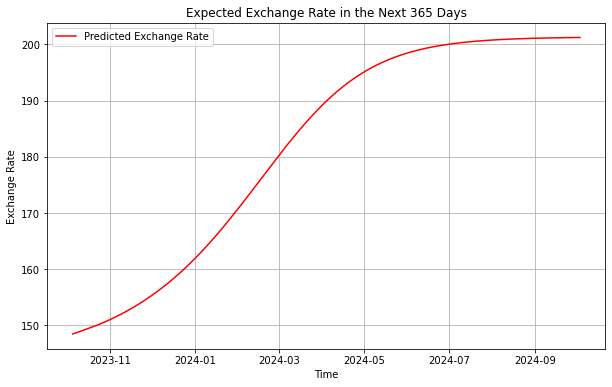

In [84]:
# Prediction for next 10 days
n_future = 365

last_date = data.index[-1]

# Creating a date range for the next 'n_future' days
forecast_period_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='D')[1:]  # we skip the very first day because it's the current day

# Initialize the list for holding predictions
future_predictions = []

# Initialize the last sequence with the last `look_back` data points
last_sequence = list(data['Mean'].tail(look_back).values)

# We will predict `n_future` days into the future
for _ in range(n_future):
    # Prepare the sequence as model input
    last_sequence_scaled = scaler.transform(np.array(last_sequence[-look_back:]).reshape(-1, 1))
    last_sequence_scaled = last_sequence_scaled.reshape((1, look_back, 1))
    
    # Make the prediction
    next_prediction = model.predict(last_sequence_scaled)
    
    # Transform back to the original scale
    next_prediction_original_scale = scaler.inverse_transform(next_prediction)[0,0]
    
    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction_original_scale)
    
    # Also append this prediction to the last sequence for the next loop iteration
    last_sequence.append(next_prediction_original_scale)

# Now that we have all predictions, we can plot them
plt.figure(figsize=(10, 6))
plt.plot(forecast_period_dates, future_predictions, color='r', label='Predicted Exchange Rate')
plt.title('Expected Exchange Rate in the Next {} Days'.format(n_future))
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

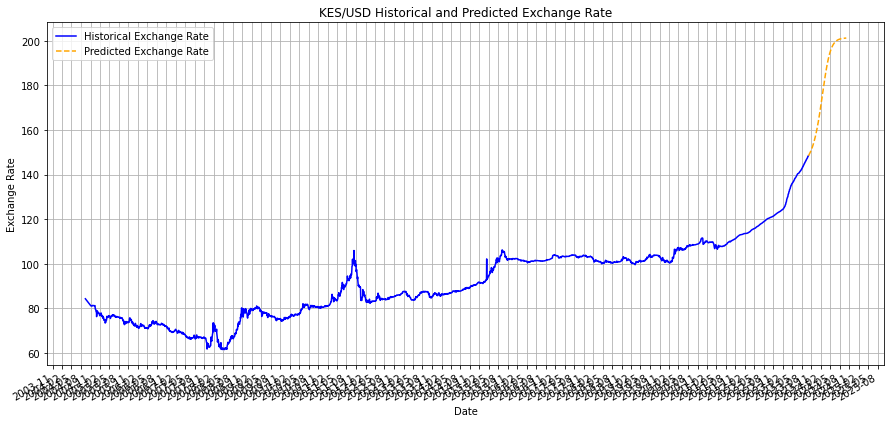

In [85]:
# Plotting the future trend + current trend

# Create a plot with a context 'talk' and a figure size
plt.figure(figsize=(15, 7))

# Plotting the original time series data
plt.plot(data.index, data['Mean'], color='blue', label='Historical Exchange Rate')

# Adding the future predictions
future_dates = forecast_period_dates
plt.plot(future_dates, future_predictions, color='orange', linestyle='dashed', label='Predicted Exchange Rate')

plt.title('KES/USD Historical and Predicted Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(visible=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # formatting the x-axis to show year-month only
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # setting interval for x-axis ticks
plt.gcf().autofmt_xdate()  # auto-formatting the x-axis date

plt.show()